# Example: Electricity price forecasting with ARX models

This notebook demonstrates how to use the electricity pricing forecasting models.

## 1. Setup

First, let's load the processed electricity and forecast data.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-colorblind')

# Load data
base_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")
df_electricity = pd.read_csv(os.path.join(base_dir, "electricity_data.csv"), parse_dates=['settlementDate'])
df_forecast = pd.read_csv(os.path.join(base_dir, "forecast_data.csv"), parse_dates=['SETTLEMENT_DATE'])

# Merge and prepare data
df_electricity.drop(columns={'startTime'}, inplace=True)
df_electricity.rename(columns={'settlementDate': 'SETTLEMENT_DATE', 'settlementPeriod': 'SETTLEMENT_PERIOD'}, inplace=True)
df = pd.merge(df_electricity, df_forecast, on=['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD'], how='inner')

# Create timezone-aware timestamps
df['timestamp_utc'] = (df['SETTLEMENT_DATE'] + pd.to_timedelta((df['SETTLEMENT_PERIOD'] - 1) * 30, unit='m')).dt.tz_localize('UTC')
df['DATETIME'] = df['timestamp_utc'].dt.tz_convert('Europe/London')
df.drop(columns=['timestamp_utc'], inplace=True)
df = df.sort_values(by='DATETIME', ascending=True).reset_index(drop=True)
df.set_index('DATETIME', inplace=True)

print(f"Data loaded: {len(df)} samples from {df.index[0]} to {df.index[-1]}")
df.head()

Data loaded: 66359 samples from 2021-01-02 00:00:00+00:00 to 2024-12-30 23:30:00+00:00


,SETTLEMENT_DATE,SETTLEMENT_PERIOD,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,...,marketIndexPrice,marketIndexTradingVolume,naturalGasPrice,DEMAND_FORECAST,EMBEDDED_WIND_FORECAST,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_FORECAST,EMBEDDED_SOLAR_CAPACITY,WIND_CAPACITY,WIND_FORECAST
DATETIME,,,,,,,,,,,,,,,,,,,,,
2021-01-02 00:00:00+00:00,2021-01-02,1,2466.0,11176.0,0.0,0.0,5923.0,0.0,3817.661,570.0,...,57.47,677.00,19.578,26422.0,879,6527,0,13082,15729,2383
2021-01-02 00:30:00+00:00,2021-01-02,2,2467.0,11235.0,0.0,0.0,5929.0,0.0,3989.388,549.0,...,60.45,655.90,19.578,26622.0,867,6527,0,13082,15729,2382
2021-01-02 01:00:00+00:00,2021-01-02,3,2456.0,11461.0,0.0,0.0,5919.0,0.0,3912.158,652.0,...,58.17,437.10,19.578,26229.0,867,6527,0,13082,15729,2398
2021-01-02 01:30:00+00:00,2021-01-02,4,2463.0,10885.0,0.0,0.0,5932.0,0.0,3891.883,524.0,...,60.20,516.80,19.578,25836.0,863,6527,0,13082,15729,2429
2021-01-02 02:00:00+00:00,2021-01-02,5,2481.0,10643.0,0.0,0.0,5928.0,0.0,3907.977,525.0,...,57.56,469.95,19.578,25443.0,863,6527,0,13082,15729,2474


## 2. Feature engineering

Create features for the ARX model:

**Autoregressive features:**
- Lagged prices from previous settlement periods (1, 2, 3 periods ago)
- Lagged prices from same period on previous days (1 day, 7 days ago)

**Exogenous variables:**
- Suppressed demand (demand forecast - embedded generation)
- Wind generation forecast
- Gas prices (lagged 2 days)

**Temporal features:**
- Holiday indicator
- Weekend indicator

In [3]:
from electricity_pricing.features import is_holiday, is_weekend, add_intercept
from electricity_pricing.utils import timeshift

# Autoregressive features: settlement period lags
for lag in [1, 2]:
    df[f'price_lag_sp_{lag}'] = df['marketIndexPrice'].shift(lag)

# Autoregressive features: day lags (handles daylight savings correctly)
for dlag in [1, 7]:
    df[f'price_lag_day_{dlag}'] = timeshift(df['marketIndexPrice'], pd.Timedelta(days=-dlag))

# Exogenous variables
df['suppressed_demand'] = df['DEMAND_FORECAST'] - df['EMBEDDED_WIND_FORECAST'] - df['EMBEDDED_SOLAR_FORECAST']
df['wind_gen'] = df['WIND_FORECAST']
df['gas_price'] = timeshift(df['naturalGasPrice'], pd.Timedelta(days=-2))

# Temporal features
df['is_holiday'] = is_holiday(df, 'SETTLEMENT_DATE', country='GB')
df['is_weekend'] = is_weekend(df, 'SETTLEMENT_DATE')

# Intercept for linear models
add_intercept(df, column_name='intercept', inplace=True)

# Drop NaN values created by lagging
df = df.dropna(how='any')

# Define features and target
feature_cols = ['price_lag_sp_1', 'price_lag_sp_2', 'price_lag_day_1', 'price_lag_day_7',
                'suppressed_demand', 'wind_gen', 'gas_price', 'is_holiday', 'is_weekend', 'intercept']
features = df[feature_cols].copy()
target = df['marketIndexPrice'].copy()

print(f"Features created: {features.shape}")
print(f"Feature names: {feature_cols}")

Features created: (53703, 10)
Feature names: ['price_lag_sp_1', 'price_lag_sp_2', 'price_lag_day_1', 'price_lag_day_7', 'suppressed_demand', 'wind_gen', 'gas_price', 'is_holiday', 'is_weekend', 'intercept']


## 3. Train-Test split

Split data into training (2021-2024) and test (2024) sets.

In [4]:
from electricity_pricing.utils import train_test_split

# Define train and test periods
train_range = [pd.to_datetime("2021-02-01").tz_localize("Europe/London"),
               pd.to_datetime("2024-02-01").tz_localize("Europe/London")]
test_range = [pd.to_datetime("2024-02-02").tz_localize("Europe/London"),
              pd.to_datetime("2024-12-01").tz_localize("Europe/London")]

X_train, X_test = train_test_split(features, train_range, test_range)
y_train, y_test = train_test_split(target, train_range, test_range)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 38538 samples
Test set: 13186 samples


## 4. Training

Train multiple ARX models with different regressors.

### 4.1 Linear ARX Model (OLS)

Train a linear ARX model using ordinary least squares regression.

In [5]:
from electricity_pricing.models import ARXModel
from electricity_pricing.regressors import LinearRegression

# Create and train model
model_ols = ARXModel(regressor=LinearRegression())
model_ols.fit(X_train.values, y_train.values)

# Display coefficients
print("Linear ARX Model Coefficients:")
for feature, coef in zip(feature_cols, model_ols.get_params()):
    print(f"  {feature:20s} = {coef:8.4f}")

Linear ARX Model Coefficients:
  price_lag_sp_1       =   1.0095
  price_lag_sp_2       =  -0.1181
  price_lag_day_1      =   0.0459
  price_lag_day_7      =   0.0219
  suppressed_demand    =   0.0001
  wind_gen             =  -0.0003
  gas_price            =   0.0915
  is_holiday           =  -1.8568
  is_weekend           =  -1.1788
  intercept            =   1.5148


### 4.2 Ridge and Lasso regression

Train regularised models that can help to prevent overfitting.

In [6]:
from sklearn.linear_model import Ridge, Lasso

# Ridge regression (L2 regularization)
model_ridge = ARXModel(regressor=Ridge(alpha=1.0))
model_ridge.fit(X_train.values, y_train.values)

# Lasso regression (L1 regularization)
model_lasso = ARXModel(regressor=Lasso(alpha=0.1, max_iter=10000))
model_lasso.fit(X_train.values, y_train.values)

print("Ridge and Lasso models trained successfully")

Ridge and Lasso models trained successfully


### 4.3 XGBoost (non-linear regression)

Train a gradient boosting model to capture non-linear relationships.

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

model_xgb = ARXModel(regressor=GradientBoostingRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    random_state=42
))
model_xgb.fit(X_train.values, y_train.values)

print("XGBoost model trained successfully")

XGBoost model trained successfully


## 5. Evaluation & visualisation

In [8]:
# Evaluate all models on the test set.

from electricity_pricing import evaluation_metrics as metrics

def evaluate_model(model, X, y, model_name):
    """Evaluate a model and return metrics."""
    y_pred = model.predict(X)
    
    return {
        'Model': model_name,
        'RMSE (£/MWh)': metrics.rmse(y, y_pred),
        'MAE (£/MWh)': metrics.mae(y, y_pred),
        'MAPE (%)': metrics.mape(y, y_pred),
        'R²': metrics.r2_score(y, y_pred)
    }

# Evaluate all models
results = [
    evaluate_model(model_ols, X_test.values, y_test.values, 'Linear OLS'),
    evaluate_model(model_ridge, X_test.values, y_test.values, 'Ridge (alpha=1.0)'),
    evaluate_model(model_lasso, X_test.values, y_test.values, 'Lasso (alpha=0.1)'),
    evaluate_model(model_xgb, X_test.values, y_test.values, 'XGBoost')
]

# Display results
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("MODEL COMPARISON - Test Set Performance")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


MODEL COMPARISON - Test Set Performance
            Model  RMSE (£/MWh)  MAE (£/MWh)  MAPE (%)       R²
       Linear OLS      8.355386     5.242331 27.292438 0.922324
Ridge (alpha=1.0)      8.355380     5.242318 27.292289 0.922324
Lasso (alpha=0.1)      8.352397     5.229281 27.083462 0.922379
          XGBoost      8.188397     5.209038 29.806957 0.925398


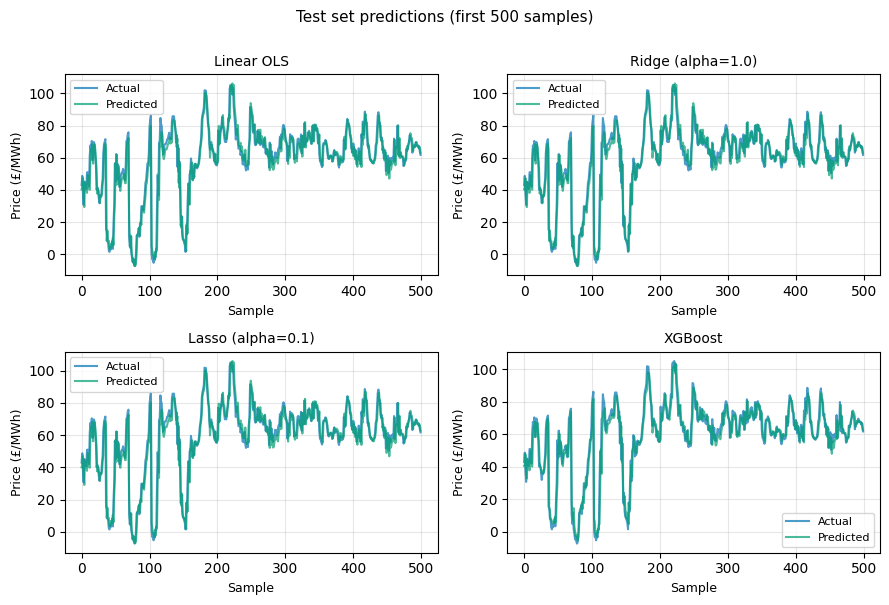

In [9]:
# Generate predictions
y_pred_ols = model_ols.predict(X_test.values)
y_pred_ridge = model_ridge.predict(X_test.values)
y_pred_lasso = model_lasso.predict(X_test.values)
y_pred_xgb = model_xgb.predict(X_test.values)

# Plot first 500 samples
fig, axes = plt.subplots(2, 2, figsize=(9, 6), layout='tight')
axes = axes.flatten()

models_to_plot = [
    (y_pred_ols, 'Linear OLS'),
    (y_pred_ridge, 'Ridge (alpha=1.0)'),
    (y_pred_lasso, 'Lasso (alpha=0.1)'),
    (y_pred_xgb, 'XGBoost')
]

for ax, (y_pred, name) in zip(axes, models_to_plot):
    ax.plot(y_test[:500], label='Actual', alpha=0.7, linewidth=1.5)
    ax.plot(y_pred[:500], label='Predicted', alpha=0.7, linewidth=1.5)
    ax.set_xlabel('Sample', fontsize=9)
    ax.set_ylabel('Price (£/MWh)', fontsize=9)
    ax.set_title(name, fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Test set predictions (first 500 samples)', fontsize=11, y=1.00)
plt.show()

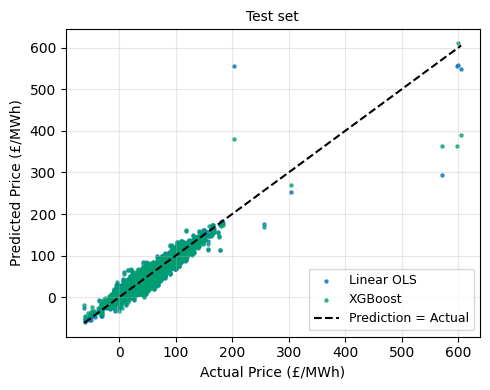

In [10]:
# Scatter plot showing predicted vs actual prices.
fig, ax = plt.subplots(figsize=(5, 4), layout='tight')

ax.scatter(y_test, y_pred_ols, alpha=0.7, s=5, label='Linear OLS')
ax.scatter(y_test, y_pred_xgb, alpha=0.7, s=5, label='XGBoost')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=1.5, label='Prediction = Actual')

ax.set_xlabel('Actual Price (£/MWh)', fontsize=10)
ax.set_ylabel('Predicted Price (£/MWh)', fontsize=10)
ax.set_title('Test set', fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

In [11]:
# Show which features are most important for the XGBoost model.

# Get feature importance
importance = model_xgb.regressor.feature_importances_

# Create DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df.to_string(index=False))


Feature Importance:
          Feature  Importance
   price_lag_sp_1    0.968587
  price_lag_day_1    0.007646
         wind_gen    0.005965
   price_lag_sp_2    0.005898
  price_lag_day_7    0.005166
        gas_price    0.003417
suppressed_demand    0.003233
       is_weekend    0.000083
       is_holiday    0.000006
        intercept    0.000000


## 6. Making day-ahead forecasts


Sample Predictions (First Day of Test Set):
 Time  Actual Price  Predicted Price (LASSO)  Error (LASSO)  Predicted Price (XGB)  Error (XGB)
    0         43.01                40.268342      -2.741658              40.562715    -2.447285
    1         48.71                41.792392      -6.917608              40.869146    -7.840854
    2         37.60                47.304629       9.704629              47.796443    10.196443
    3         30.70                35.079117       4.379117              35.886176     5.186176
    4         45.20                29.325590     -15.874410              32.742482   -12.457518
    5         43.96                44.626710       0.666710              44.423586     0.463586
    6         43.83                41.375627      -2.454373              40.221250    -3.608750
    7         40.50                41.086139       0.586139              42.197032     1.697032
    8         50.88                38.145535     -12.734465              37.829230   -13.05

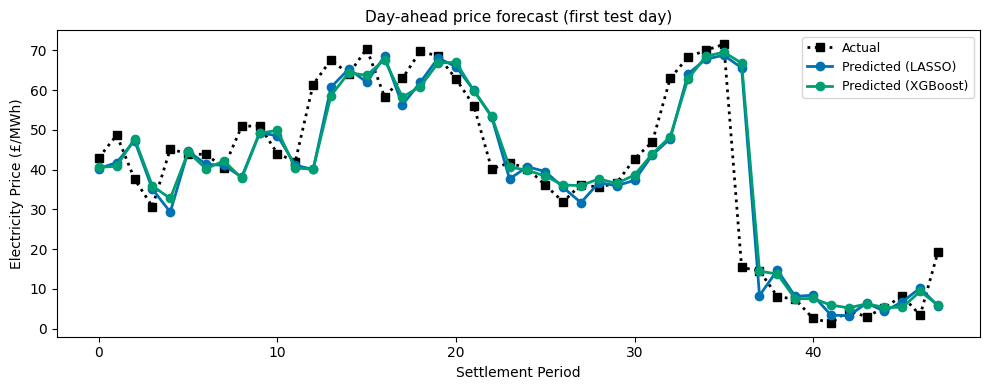

In [18]:
# Take a sample from the test set
sample_features = X_test.iloc[:48].values  # First 48 periods (one day)

# Make predictions
predictions_lasso = model_ols.predict(sample_features)
predictions_xgb = model_xgb.predict(sample_features)

sample_times = X_test.index[:48]
actual_prices = y_test.iloc[:48].values

results_sample = pd.DataFrame({
    'Time': sample_times,
    'Actual Price': actual_prices,
    'Predicted Price (LASSO)': predictions_lasso,
    'Error (LASSO)': predictions_lasso - actual_prices,
    'Predicted Price (XGB)': predictions_xgb,
    'Error (XGB)': predictions_xgb - actual_prices
})

print("\nSample Predictions (First Day of Test Set):")
print(results_sample.head(10).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 4), layout='tight')
ax.plot(range(48), actual_prices, marker='s', ls=':', color='black', label='Actual', linewidth=2)
ax.plot(range(48), predictions_lasso, marker='o', label='Predicted (LASSO)', linewidth=2)
ax.plot(range(48), predictions_xgb, marker='o', label='Predicted (XGBoost)', linewidth=2)
ax.set_xlabel('Settlement Period', fontsize=10)
ax.set_ylabel('Electricity Price (£/MWh)', fontsize=10)
ax.set_title('Day-ahead price forecast (first test day)', fontsize=11)
ax.legend(fontsize=9)
plt.show()